# Learning sampling pattern
Second version of the full algorithm:
- Several images possible
- Learning points or cartesian mask

In [1]:
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN
import pysap
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from modopt.math.metrics import ssim
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
# Lower level imports
from LowerLevel.pdhg import pdhg

#Upper level imports
import time
from UpperLevel.LBFGSB import *
from UpperLevel.cost_utils import *

### Creation of Lower level tools
Creating fourier_op, linear_op and param.

In [3]:
#Size of images to use
n = 50

x = np.linspace(0,n,n,endpoint=False)/n-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

m = convert_locations_to_mask(kspace_loc,(n,n))
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=(n,n),implementation='cpu')

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


In [4]:
#Wavelet
linear_op = WaveletN(wavelet_name="sym8",nb_scale=1,padding_mode = "periodization")
#linear_op = WaveletUD2(wavelet_id=24,nb_scale=3)

param = {"epsilon":1e-2,"gamma":1e-10}

### Initializing upper level
Creating images, kspace_data and updating param

In [5]:
#Oasis image
all_images = [ "oasis_data/sub-OAS30001_ses-d0129_run-01_T1w.nii"]
              #,"../oasis_data/sub-OAS30278_ses-d1325_run-02_T1w.nii" ]
im = nib.load("oasis_data/sub-OAS30001_ses-d0129_run-01_T1w.nii")
im = im.get_fdata()

Nimages = 3
images = [(1+0j)*im[ :, 30:206, i ]for i in range(124,124+Nimages)]

In [6]:
def reduce_img_size( n_dim, image ):
    mid = image.shape[ 0 ] // 2
    f_coef = np.fft.fftshift( np.fft.fft2( image ) )
    reduced_coef = f_coef[ mid - n_dim // 2: mid + n_dim // 2, mid - n_dim // 2: mid + n_dim // 2 ]
    reduced_image = np.fft.ifft2( np.fft.fftshift( reduced_coef ) )
    return np.abs( reduced_image )

images = [reduce_img_size(n,im) for im in images]
kspace_data = [(1+0j)*fourier_op.op(u0_mat)+0.1*np.mean(u0_mat)*np.random.randn(2*n*n).view(np.complex128) 
               for u0_mat in images]

In [7]:
param["c"] = 1e-7
param["beta"] = 1e-4

In [8]:
# -- Main object to learn mask --
# -------------------------------
obj = Mask_Learner(images=images,kspace_data=kspace_data,
                    fourier_op=fourier_op , linear_op=linear_op , param=param , 
                    verbose=-1 , my_const={"sigma":5,"tau":0.1})

# Learning points independantly

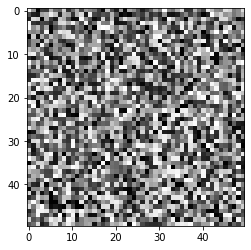

In [9]:
p0 = np.random.rand(n**2+1)
p0[-1] = 1e-2

plt.figure()
plt.imshow(np.reshape(p0[:-1],(n,n)),cmap='gray')
plt.show()

In [10]:
pf,energy_upper,alphas = obj.optimize(p0=p0)

/home/guillaume/pysap-mri/Learning Sampling Pattern/LowerLevel/prox.py:19: RuntimeWarning: invalid value encountered in sqrt
  x/np.abs(x)*(gamma+gamma**2/2/c-gamma/c*np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))



1 iterations: E(p)=80.88762622094728, alpha=0.748134510304429



2 iterations: E(p)=41.350167744025576, alpha=1.1506307576750572



3 iterations: E(p)=28.553897987122223, alpha=1.3911030181689923



4 iterations: E(p)=17.809433782797562, alpha=1.75614079263157



5 iterations: E(p)=10.904746703005733, alpha=2.021451718178707



6 iterations: E(p)=8.176173319844604, alpha=2.2885499667505758



7 iterations: E(p)=7.347376673374454, alpha=2.519344827147225



8 iterations: E(p)=7.04273332422312, alpha=2.5804496152013336



9 iterations: E(p)=6.7720247893838525, alpha=2.7288124129231113



10 iterations: E(p)=6.308901850108937, alpha=3.1570885294867805



11 iterations: E(p)=5.896409589603948, alpha=3.759091031536495



12 iterations: E(p)=5.565351266417458, alpha=4.728509767771455



13 iterations: E(p)=5.357170274413768, alpha=6.132142436147193



14 iterations: E(p)=5.305593991128331, alpha=8.370379459289776



15 iterations: E(p)=5.255419550745703, alpha=9.296514353405271



16 iterat

158.00518906595101 5.195605690206815


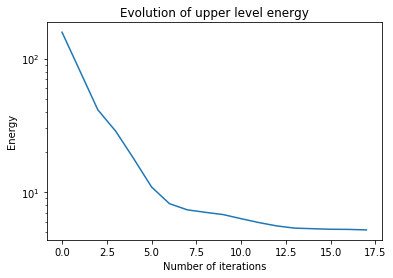

In [11]:
print(energy_upper[0],energy_upper[-1])
plt.plot(energy_upper)
plt.title("Evolution of upper level energy")
plt.xlabel("Number of iterations")
plt.ylabel("Energy")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Penalty_strength_V2/high_pen/convergence.png")

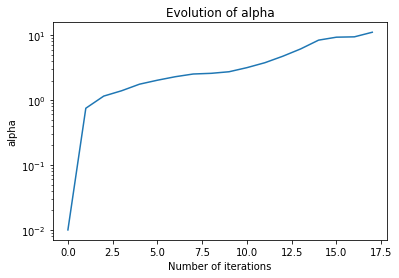

In [12]:
plt.plot(alphas)
plt.title("Evolution of alpha")
plt.xlabel("Number of iterations")
plt.ylabel("alpha")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Penalty_strength_V2/high_pen/alpha.png")

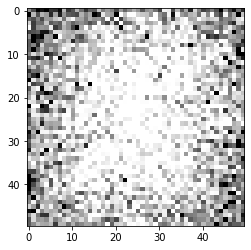

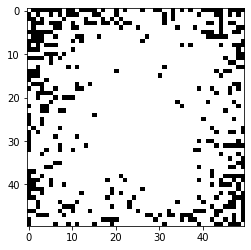

In [13]:
ceiled_pf = np.where(pf>0.5,1,0)
ceiled_pf[-1]=pf[-1]

plt.figure()
plt.imshow(np.reshape(pf[:-1],(n,n)),cmap='gray')
plt.figure()
plt.imshow(np.reshape(ceiled_pf[:-1],(n,n)),cmap='gray')
plt.show()

In [14]:
pysap.Image(data=np.reshape(pf[:-1],(n,n))).show()

In [15]:
print("Penalty:",P(pf,param["beta"]),
      "\nEnergy:",E(pk=pf , images=images , kspace_data=kspace_data , fourier_op=fourier_op ,
           linear_op=linear_op , param=param , verbose=-1 , const=obj.const),
      "\nNumber of points:",np.sum(ceiled_pf))

Penalty: 0.2198706739539505 
Energy: 5.195605690206815 
Number of points: 2105


In [16]:
# -- Compute mean ssim of final mask and its ceiled version --
mean_ssim_pf = 0
mean_ssim_ceiled = 0

for itest in range(Nimages):
    uk,norms = pdhg(kspace_data[itest] , ceiled_pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const)
    mean_ssim_ceiled += ssim(uk,images[itest])
    
    uk,norms = pdhg(kspace_data[itest] , pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const)
    mean_ssim_pf += ssim(uk,images[itest])
print(f"\nMean ssim: {mean_ssim_pf/Nimages}\nMean ssim ceiled mask:{mean_ssim_ceiled/Nimages}")


Mean ssim: 0.9719848987468249
Mean ssim ceiled mask:0.9662934151381064


# Learning cartesian mask

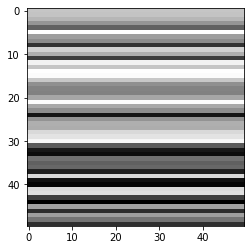

In [17]:
l0 = np.random.rand(n+1)
l0[-1] = 1e0

param["beta"] = 1e-2

# -- Main object to learn mask --
# -------------------------------
obj = Mask_Learner(images=images,kspace_data=kspace_data,
                    fourier_op=fourier_op , linear_op=linear_op , param=param , 
                    verbose=-1 , my_const={"sigma":5,"tau":0.1} , maxiter=40 , maxfun=40)

cartesian_p = pcart(l0)
cartesian_p[-1] = l0[-1]

plt.figure()
plt.imshow(np.reshape(cartesian_p[:-1],(n,n)),cmap='gray')
plt.show()

In [ ]:
lf,energy_upper,alphas = obj.optimize(mask_type = "cartesian" , l0=l0)


1 iterations: E(p)=81.71176568422966, alpha=1.4001528007973645



2 iterations: E(p)=46.909511895670164, alpha=1.644422120612899



3 iterations: E(p)=28.475122679733882, alpha=1.8835252318406106



4 iterations: E(p)=17.173710600266933, alpha=2.079427564174427



5 iterations: E(p)=11.719381782812556, alpha=2.2372370926731824



6 iterations: E(p)=9.031964094208853, alpha=2.346113120100786



7 iterations: E(p)=7.935540510983714, alpha=2.4181576323734704



8 iterations: E(p)=7.45764282773783, alpha=2.459166484307505



9 iterations: E(p)=7.267974840717933, alpha=2.4792452092400032



10 iterations: E(p)=7.162202979180538, alpha=2.483358794203022



11 iterations: E(p)=7.07997823214979, alpha=2.4715885142845333



12 iterations: E(p)=6.99963208721735, alpha=2.4340067372144367




In [ ]:
print(energy_upper[0],energy_upper[-1])
plt.plot(energy_upper)
plt.title("Evolution of upper level energy")
plt.xlabel("Number of iterations")
plt.ylabel("Energy")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Multiple images/10 images/convergence.png")

In [ ]:
plt.plot(alphas)
plt.title("Evolution of alpha")
plt.xlabel("Number of iterations")
plt.ylabel("alpha")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Multiple images/10 images/alpha.png")

In [ ]:
print(lf[-1])
pf = pcart(lf)
ceiled_pf = np.where(pf>0.9,1,0)

plt.figure()
plt.imshow(np.reshape(pf[:-1],(n,n)),cmap='gray',vmin=0,vmax=1)
plt.figure()
plt.imshow(np.reshape(ceiled_pf[:-1],(n,n)),cmap='gray')
plt.show()

In [ ]:
print(P(lf,param["beta"]),
E(lk=lf , mask_type = "cartesian" , images=images , kspace_data=kspace_data , fourier_op=fourier_op ,
           linear_op=linear_op , param=param , verbose=-1 , const=obj.const),
np.sum(ceiled_pf))

In [ ]:
mean_ssim_pf = 0
mean_ssim_ceiled = 0

for itest in range(Nimages):
    uk,norms = pdhg(kspace_data[itest] , ceiled_pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const)
    mean_ssim_ceiled += ssim(uk,images[itest])
    
    uk,norms = pdhg(kspace_data[itest] , pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const)
    mean_ssim_pf += ssim(uk,images[itest])
print(f"\nMean ssim: {mean_ssim_pf/Nimages}\nMean ssim ceiled mask:{mean_ssim_ceiled/Nimages}")